In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm.notebook import tqdm

In [2]:
def read_file(path):
    try:
        with open(path) as f:
            data = f.readlines()
        if len(data) == 3:
            print(f"Problem in {path}:")
            print(data)
            return None
        return data
    except:
        print(f"Error reading {path}")
        return None

In [3]:
def get_start_end(data):
    for i, d in enumerate(data):
        if 'classes' in d:
            start = i
        if 'Score Average' in d:
            end = i
            return start, end

In [4]:
def get_miou(dataset, start, end):
    result = np.zeros(20)
    i = 0
    for data in dataset[start:end+1]:
        data = data.strip().split(':')
        if len(data) > 1:
            miou = float(data[1].split()[0])
            result[i] = miou
            i += 1

    return result.reshape((1, 20))

def get_classnames(dataset, start, end):
    res = []
    for data in dataset[start:end+1]:
        data = data.strip().split(':')
        if len(data) > 1:
            res.append(data[0].strip())
    return res

In [15]:
model, layer = 'dino', 12

path = f'./openseg.pytorch/cs4pc_{model}_256_val_knn_72_train_30_val_layer_{layer}.txt'
classnames = get_classnames(read_file(path), *get_start_end(read_file(path)))

In [5]:
models = ['sup_vit', 'dino', 'dinov2', 'mae', 'simmim']
degradations = ['blur', 'noise', 'frequency_noise']
layers = range(1,13)
classes = ['road','vegetation','building','car','sky','person','bicycle','traffic sign','terrain','sidewalk','pole','fence','bus','truck','traffic light','rider','wall','train','motorcycle','Average']
model_title = {
    'dino': "DINO",
    'dinov2': "DINOv2",
    'sup_vit': "Supervised ViT",
    'mae': "MAE",
    'simmim': "SimMIM",
}

In [6]:
results_knn = np.zeros((len(degradations), len(models), 5, len(layers), 20))
results_linear = np.zeros((len(degradations), len(models), 5, len(layers), 20))
results_knn.shape

(3, 5, 5, 12, 20)

In [17]:
def get_results(algo, results):
    for di, degradation in enumerate(degradations):
        all_models = []
        for model in models:
            blured = []
            layers_ = []

            for layer in layers:
                if algo == 'knn':
                    path = f'./openseg.pytorch/cs4pc_{model}_256_val_knn_72_train_30_val_layer_{layer}.txt'
                elif algo == 'linear':
                    path = f'./openseg.pytorch/{model}_val_cs_patches_256_linear_layer_{layer}.txt'
                dataset = read_file(path)
                if dataset is None:
                    layers_.append(np.zeros((1,20)))
                else:
                    start, end = get_start_end(dataset)
                    miou = get_miou(dataset, start, end)
                    layers_.append(miou)
            layers_ = np.concatenate(layers_, axis=0)
            layers_ = layers_.reshape(1, *layers_.shape)
            blured.append(layers_)

            if degradation == 'frequency_noise':
                levels = [4,3,2,1]
            elif degradation == 'noise':
                levels = [10, 20, 30, 40]
            else:
                levels = [1,2,3,4]
            for blur in levels:
                layers_ = []
                for layer in layers:
                    if algo == 'knn':
                        path = f'./openseg.pytorch/{model}_val_cs_patches_256_knn_train_72_val_30_{degradation}_{blur}_layer_{layer}.txt'
                    elif algo == 'linear':
                        path = f'./openseg.pytorch/{model}_val_cs_patches_256_linear_{degradation}_{blur}_layer_{layer}.txt'
                    dataset = read_file(path)
                    if dataset is None:
                        layers_.append(np.zeros((1,20)))
                    else:
                        start, end = get_start_end(dataset)
                        miou = get_miou(dataset, start, end)
                        layers_.append(miou)
                layers_ = np.concatenate(layers_, axis=0)
                layers_ = layers_.reshape(1, *layers_.shape)
                blured.append(layers_)
            blured = np.concatenate(blured, axis=0)
            blured = blured.reshape(1, *blured.shape)
            all_models.append(blured)
        all_models = np.concatenate(all_models, axis=0)
        results[di] = all_models
    return None


In [8]:
get_results('knn', results_knn)
get_results('linear', results_linear)

Problem in ./openseg.pytorch/dinov2_val_cs_patches_256_knn_train_72_val_30_noise_30_layer_7.txt:
['/home/hkhachatrian/mae/evaluation/cs/dinov2_cs_patches_256_knn_train_72_val_30_noise_30_layer_7/val_pred\n', 'evaluate the result...\n', 'ERROR: Found no prediction for ground truth /home/hkhachatrian/mae/evaluation/cs/gt/val/munster_000046_000019_leftImg8bit.png\n']
Error reading ./openseg.pytorch/sup_vit_val_cs_patches_256_linear_layer_1.txt
Error reading ./openseg.pytorch/sup_vit_val_cs_patches_256_linear_layer_2.txt
Error reading ./openseg.pytorch/sup_vit_val_cs_patches_256_linear_layer_3.txt
Error reading ./openseg.pytorch/sup_vit_val_cs_patches_256_linear_layer_4.txt
Error reading ./openseg.pytorch/sup_vit_val_cs_patches_256_linear_layer_5.txt
Error reading ./openseg.pytorch/sup_vit_val_cs_patches_256_linear_layer_6.txt
Error reading ./openseg.pytorch/sup_vit_val_cs_patches_256_linear_layer_7.txt
Error reading ./openseg.pytorch/sup_vit_val_cs_patches_256_linear_layer_8.txt
Error rea

In [9]:
# np.save('./results/dinov2_dino_mae_svit_blur1_4_layers1_12_class_miou.npy', all_models)

In [10]:
# all_models = np.load('./results/dinov2_dino_mae_svit_blur1_4_layers1_12_class_miou.npy')

In [ ]:

fig, ax = plt.subplots(4, 5, figsize=(15,10))
for ci, cat in enumerate(classnames):
    x, y = ci%5, ci//5
    for mi, model in enumerate(('dinov2', 'dino', 'mae', 'sup_vit')):
        ax[y,x].plot(all_models[mi, :, -1, ci], label=model)
#         ax[y,x].plot(all_models[mi, :, -1, ci] / all_models[mi, 0, -1, ci], label=model)
    ax[y,x].title.set_text(cat)
    ax[y,x].set_ylim(0, 1.0)
    ax[y,x].set_xticks(range(5))
    if degradation == 'frequency_noise':
        ax[y,x].set_xticklabels(['Original', 'Low freq', '', '', 'High freq'])
    else:
        ax[y,x].set_xticklabels(10*np.arange(5))
ax[y,x].legend();
if degradation == 'blur':
    ax[y,x].set_xlabel("Blur kernel radius")
if degradation == 'noise':
    ax[y,x].set_xlabel("Noise std")
if degradation == 'frequency_noise':
    ax[y,x].set_xlabel("Frequency noise band")
plt.tight_layout();

# Figures for the paper

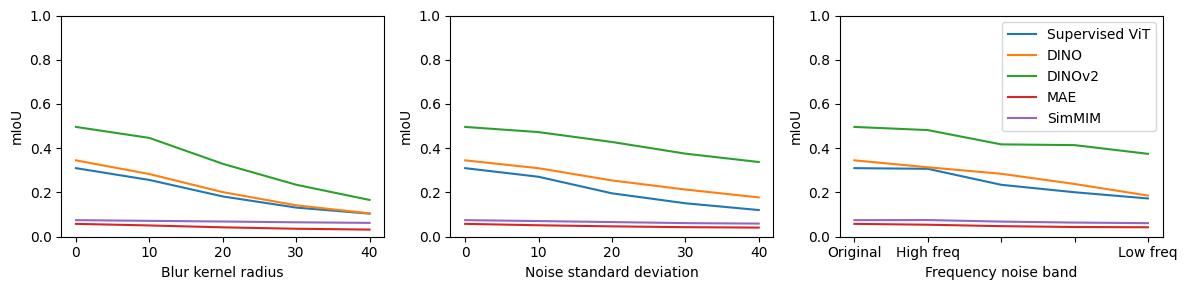

In [18]:
fig, ax = plt.subplots(1,3, figsize=(12,3))
for di, degradation in enumerate(degradations):
    for mi, model in enumerate(models):
        ax[di].plot(results_knn[di, mi, :, -1, -1], label=model_title[model])
    #     plt.plot(results[0, mi, :, -1, -1] / results[0, mi, 0, -1, -1], label=model)
    ax[di].set_ylim(0, 1.0)
    ax[di].set_xticks(range(5))
    ax[di].set_xticklabels(10*np.arange(5))

    if degradation == 'frequency_noise':
        ax[di].set_xticklabels(['Original', 'High freq', '', '', 'Low freq'])
    else:
        ax[di].set_xticklabels(10*np.arange(5))
    ax[di].set_ylabel('mIoU')
    
    if degradation == 'blur':
        ax[di].set_xlabel("Blur kernel radius")
    if degradation == 'noise':
        ax[di].set_xlabel("Noise standard deviation")
    if degradation == 'frequency_noise':
        ax[di].set_xlabel("Frequency noise band")
    
ax[-1].legend();
plt.tight_layout();

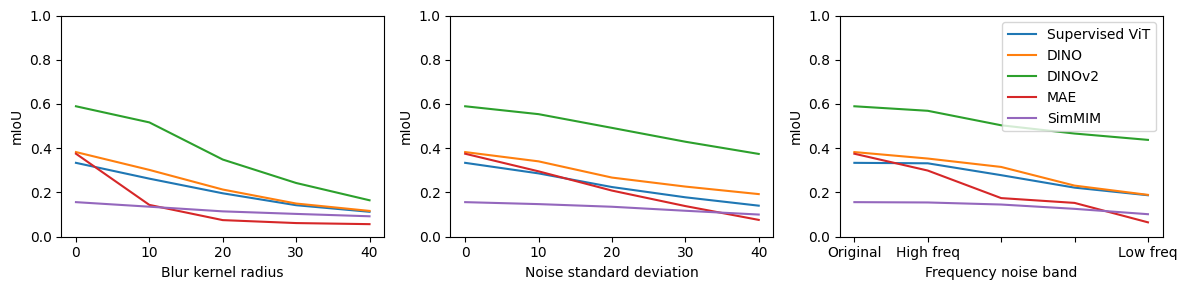

In [13]:
fig, ax = plt.subplots(1,3, figsize=(12,3))
for di, degradation in enumerate(degradations):
    for mi, model in enumerate(models):
        ax[di].plot(results_linear[di, mi, :, -1, -1], label=model_title[model])
    #     plt.plot(results[0, mi, :, -1, -1] / results[0, mi, 0, -1, -1], label=model)
    ax[di].set_ylim(0, 1.0)
    ax[di].set_xticks(range(5))
    ax[di].set_xticklabels(10*np.arange(5))

    if degradation == 'frequency_noise':
        ax[di].set_xticklabels(['Original', 'High freq', '', '', 'Low freq'])
    else:
        ax[di].set_xticklabels(10*np.arange(5))
    ax[di].set_ylabel('mIoU')
    
    if degradation == 'blur':
        ax[di].set_xlabel("Blur kernel radius")
    if degradation == 'noise':
        ax[di].set_xlabel("Noise standard deviation")
    if degradation == 'frequency_noise':
        ax[di].set_xlabel("Frequency noise band")
    
ax[-1].legend();
plt.tight_layout();

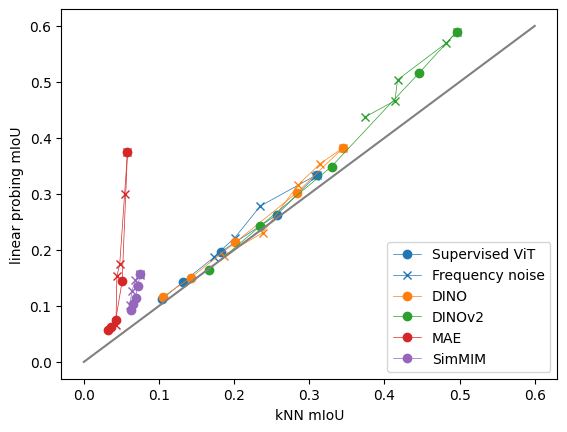

In [19]:
plt.figure()
lw = 0.5
for mi, model in enumerate(models):
#     if model != 'dinov2':
#         continue
    plt.plot(results_knn[0, mi, :, -1, -1], # / results_knn[0, mi, 0, -1, -1],
             results_linear[0, mi, :, -1, -1], # / results_linear[0, mi, 0, -1, -1], 
             marker='o', color=f'C{mi}', 
             linewidth=lw, label=model_title[model])

#     plt.plot(results_knn[1, mi, :, -1, -1], results_linear[1, mi, :, -1, -1], marker='+', color=f'C{mi}', 
#              linewidth=lw, label='Noise' if mi == 0 else None)

    plt.plot(results_knn[2, mi, :, -1, -1], results_linear[2, mi, :, -1, -1], marker='x', color=f'C{mi}', 
             linewidth=lw, label='Frequency noise' if mi==0 else None)

plt.plot([0, 0.6], [0, 0.6], color='grey')
    
plt.legend(loc='lower right')
plt.xlabel("kNN mIoU")
plt.ylabel("linear probing mIoU");

In [20]:
degradations

['blur', 'noise', 'frequency_noise']

In [21]:
degradation_title = dict(zip(degradations, ['Blur', 'Noise', 'Frequency Noise']))

In [22]:
shifts = {
    'blur': ['2px','4px','6px','8px'],
    'noise': [10,20,30,40],
    'frequency_noise': ['high', '', '', 'low']
}

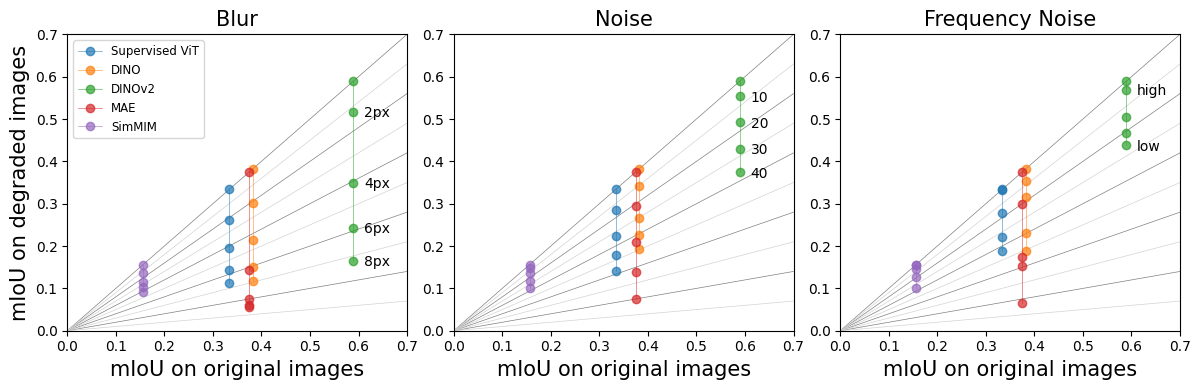

In [23]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

for di, degradation in enumerate(degradations):
    max_value = 0.7
    for coef in np.arange(0.2, 1.1, 0.2):
        ax[di].plot([0, max_value], [0, max_value * coef], color='grey', linewidth=0.5)
    for coef in np.arange(0.1, 1.1, 0.2):
        ax[di].plot([0, max_value], [0, max_value * coef], color='lightgrey', linewidth=0.5)

    lw = 0.5
    for mi, model in enumerate(models):
    #     if model != 'dinov2':
    #         continue
        ax[di].plot(np.repeat(results_linear[di, mi, :1, -1, -1], 5, axis=0), 
                 results_linear[di, mi, :, -1, -1], alpha=0.7,
                 marker='o', color=f'C{mi}', linewidth=lw, label=model_title[model])
    mi = 2
    for si, shift in enumerate(shifts[degradation]):
        ax[di].text(
            x=results_linear[di, mi, 0, -1, -1] + 0.022,
            y=results_linear[di, mi, si+1, -1, -1] - 0.013,
            s=shift,
            color='k'
        )

    ax[di].set_title(degradation_title[degradation], fontsize=15)
    ax[di].set_xlim(0, max_value)
    ax[di].set_ylim(0, max_value)
    ax[di].set_xlabel("mIoU on original images", fontsize=15)
ax[0].set_ylabel("mIoU on degraded images", fontsize=15)
ax[0].legend(fontsize=8.5);
plt.tight_layout()
plt.savefig('jupyter_notebooks/images/cityscapes-degradation.pdf')
    

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(12,3))

# Define a colormap that goes from light blue to dark blue
cmap = mcolors.LinearSegmentedColormap.from_list("mycmap", ['lightblue', 'darkblue'])
cmap = mcolors.LinearSegmentedColormap.from_list("mycmap", ['yellow', 'red', 'magenta', 'darkblue'])

for mi, model in enumerate(('dinov2', 'dino', 'mae', 'sup_vit')):
    for layer in range(12):
        # Select a color from the colormap
        color = cmap(layer / 12)
        ax[mi].plot(all_models[mi, :, layer, -1] / all_models[mi, 0, layer, -1], label=layer + 1, color=color)
#         ax[mi].plot(all_models[mi, :, layer, -1], label=layer + 1, color=color)

    
    ax[mi].set_ylim(0, 1.0)
    ax[mi].set_xlim(0, 1.0)
    ax[mi].set_xticks(range(5))
    ax[mi].set_xticklabels(10*np.arange(5))
    ax[mi].title.set_text(model)
    if degradation == 'blur':
        ax[mi].set_xlabel("Blur kernel radius")
    if degradation == 'noise':
        ax[mi].set_xlabel("Noise standard deviation")

ax[0].set_ylabel('Relative robustness (mIoU)')
ax[-1].legend();
    
plt.tight_layout();